In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from wirenec.geometry import Wire, Geometry
from wirenec.visualization import plot_geometry
from wirenec.visualization import scattering_plot

In [2]:
from wirenec_optimization.parametrization.base_parametrization import (
    BaseObjectParametrization,
)


class SphereParametrization(BaseObjectParametrization):
    def __init__(self, max_size: float = 25 * 1e-3, min_size: float = 25 * 1e-3):
        super().__init__("Sphere", max_size, min_size)

    @staticmethod
    def __parametrize_sphere__(r, phi_lines, theta_lines):
        phi = np.linspace(0, np.pi, phi_lines)
        theta = np.linspace(0, 2 * np.pi, theta_lines)
        segments = []

        # Go through each line of constant latitude (phi)
        for i in range(phi_lines):
            for j in range(theta_lines - 1):
                # Convert to cartesian coordinates
                x1, y1, z1 = (
                    r * np.sin(phi[i]) * np.cos(theta[j]),
                    r * np.sin(phi[i]) * np.sin(theta[j]),
                    r * np.cos(phi[i]),
                )
                x2, y2, z2 = (
                    r * np.sin(phi[i]) * np.cos(theta[j + 1]),
                    r * np.sin(phi[i]) * np.sin(theta[j + 1]),
                    r * np.cos(phi[i]),
                )

                # Store the segment
                segment = [(x1, y1, z1), (x2, y2, z2)]
                segments.append(segment)

        # Go through each line of constant longitude (theta)
        for i in range(theta_lines):
            for j in range(phi_lines - 1):
                # Convert to cartesian coordinates
                x1, y1, z1 = (
                    r * np.sin(phi[j]) * np.cos(theta[i]),
                    r * np.sin(phi[j]) * np.sin(theta[i]),
                    r * np.cos(phi[j]),
                )
                x2, y2, z2 = (
                    r * np.sin(phi[j + 1]) * np.cos(theta[i]),
                    r * np.sin(phi[j + 1]) * np.sin(theta[i]),
                    r * np.cos(phi[j + 1]),
                )

                # Store the segment
                segment = [(x1, y1, z1), (x2, y2, z2)]
                segments.append(segment)

        segments = segments[: len(segments) - phi_lines + 1]
        return segments

    def get_geometry(
        self,
        size_ratio,
        orientation,
        wire_radius: float = 0.5 * 1e-4,
        phi_segments: int = 5,
        theta_segments: int = 5,
    ):
        radius = self.min_size + (self.max_size - self.min_size) * size_ratio

        segments = self.__parametrize_sphere__(radius, phi_segments, theta_segments)

        g = Geometry([Wire(*np.around(s, 10), radius=wire_radius) for s in segments])
        g.rotate(*orientation)
        return g

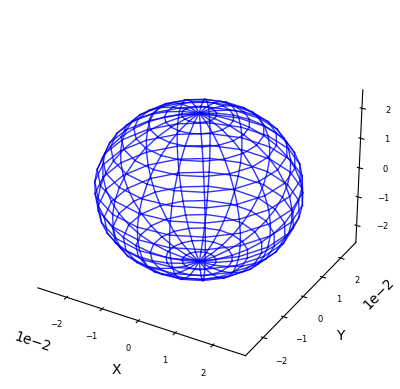

In [3]:
sphere = SphereParametrization()
plot_geometry(sphere.get_geometry(0, (0, 0, 0), phi_segments=20, theta_segments=20))

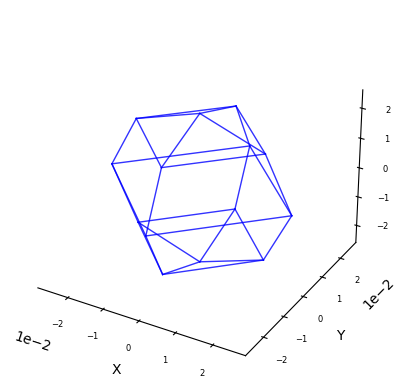

In [4]:
g = sphere.get_geometry(0, (0, 0, 0))
plot_geometry(g)

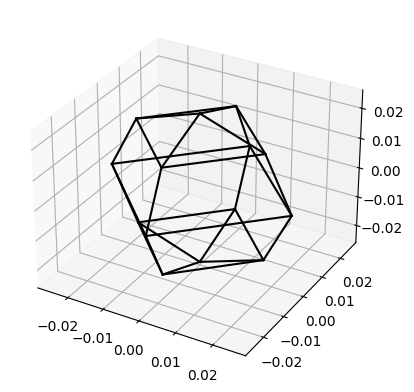

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

segments = [(w.p1, w.p2) for w in g.wires]
for segment in segments:
    x, y, z = np.transpose(segment)
    ax.plot(x, y, z, color="k")

plt.show()

100%|██████████| 100/100 [00:01<00:00, 67.29it/s]


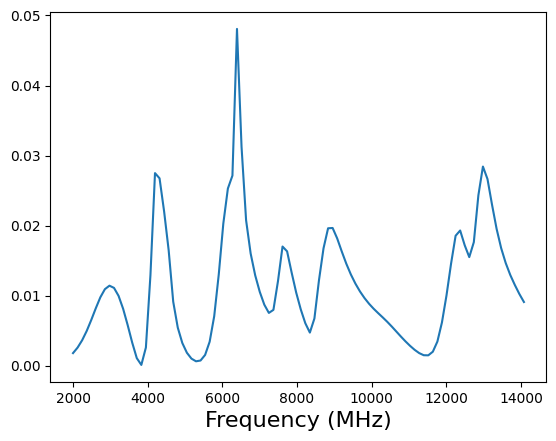

In [6]:
fig, ax = plt.subplots()
_, init_scat = scattering_plot(ax, g, num_points=100, eta=90);

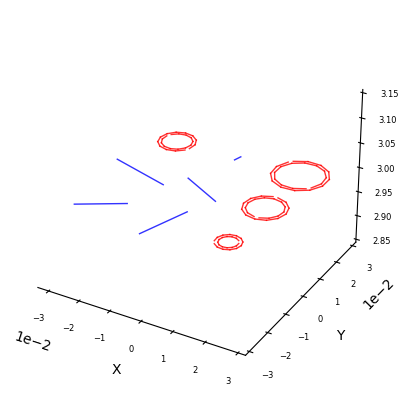

In [7]:
from wirenec_optimization.parametrization.layers_parametrization import (
    LayersParametrization,
)

hyper_params = {
    "matrix_size": (3, 3),
    "layers_num": 1,
    "tau": 20 * 1e-3,
    "delta": 10 * 1e-3,
    "asymmetry_factor": None,
}
param = LayersParametrization(**hyper_params)
g_meta = param.get_random_geometry(seed=40)
g_meta.translate((0, 0, 30e-3))

plot_geometry(g_meta)

In [8]:
# %matplotlib notebook

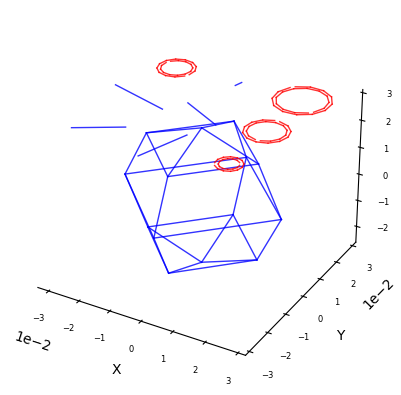

In [9]:
g_extended = Geometry([*g.wires, *g_meta.wires])
plot_geometry(g_extended)

100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


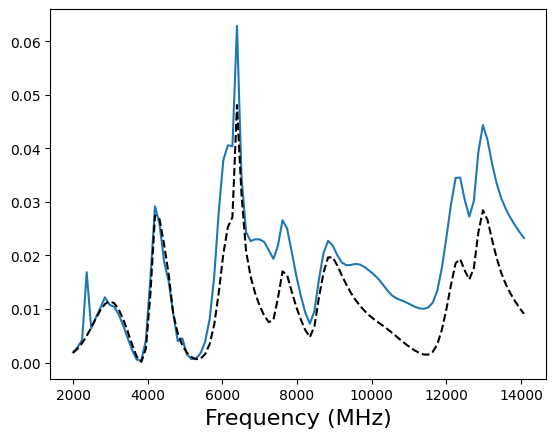

In [10]:
fig, ax = plt.subplots()
fr, scat = scattering_plot(ax, g_extended, num_points=100, eta=90)
ax.plot(fr, init_scat, color="k", ls="--")